# 14. Ajuste avanzado modelo Logistic Regression clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No     |
| :-------                  | :------:    |
| Escalado de datos         | No          |
| Ajuste de hiperparametros | Si          |
| Sobremuestreo             | Si          |
| Ajuste de pesos de clase  | Si          |
| Incluye variable ciclo    | Si          |


### Cargar librerias

In [38]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import pandas_profiling
np.random.seed(9999) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report

# sobremuestreo
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot
from numpy import arange
from pprint import pprint
from sklearn.metrics import fbeta_score

### Funciones

In [39]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test, label_pred)
    #print(matriz)
    classes = ["Funcional","Falla potencial"]
    cm = ConfusionMatrix(modelo, classes=classes, label_encoder={0:"Funcional", 1:"Falla Potencial"})
    cm.fit(data_train, label_train)
    cm.score(data_test, label_test)
    cm.show()
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
    
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
   
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [40]:
# ruta para grabar medidas de desempeño
ruta4a = "D:/alexh/Documents/Maestria en estadistica/proyecto de grado/cuadernos proyecto/Nasa Turbo Fan/Modelos 4a.xlsx"
writer = pd.ExcelWriter(ruta4a, engine='openpyxl')

### Preparar datos agil

In [41]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train['clase2']=train['clase1']
train.loc[train['ttf']<=15, 'clase2'] =2
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test['clase2']=test['clase1']
test.loc[test['ttf']<=15, 'clase2'] =2

# incluyendo la variable ciclo ID
data_train=train.iloc[:,np.r_[1:26]]
label_train=train.iloc[:,27]
data_test=test.iloc[:,np.r_[1:26]]
label_test=test.iloc[:,27]
label_train2=train.iloc[:,28]
label_test2=test.iloc[:,28]



Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

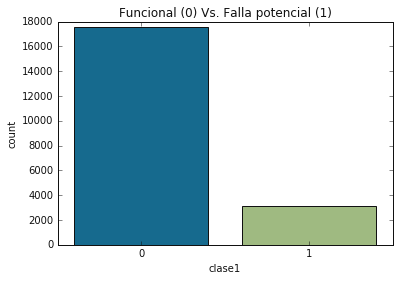

In [42]:
# conteo de observaciones por clase de la base entrenamiento
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [43]:
# sobremuestreo de minorías sintéticas (SMOTE)

data_traino, label_traino = SMOTE().fit_resample(data_train, label_train)
print(sorted(Counter(label_traino).items()))

[(0, 17531), (1, 17531)]


In [44]:
label_train=pd.Series(label_traino)

Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

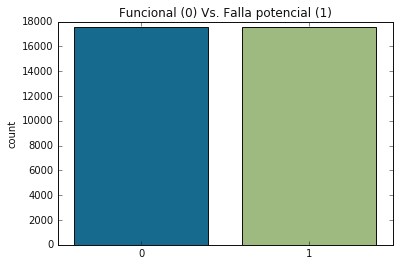

In [45]:
# grafica de base de entrenamiento equilibrada
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [46]:
data_train= pd.DataFrame(data_traino, columns=data_train.columns)

In [47]:
print("numero de dimensiones =", data_train.ndim)
print("tamaño de la tabla =", data_train.shape)
print("total datos =", data_train.size)

numero de dimensiones = 2
tamaño de la tabla = (35062, 25)
total datos = 876550


In [48]:
print("numero de dimensiones =", label_train.ndim)
print("tamaño de la tabla =", label_train.shape)
print("total datos =", label_train.size)

numero de dimensiones = 1
tamaño de la tabla = (35062,)
total datos = 35062


In [49]:
data_train.head()

,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044


## Modelos de clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo

## Logistic regression Classifier hiperparametros por defecto

In [13]:
modelo1=LogisticRegression()
modelo1.fit(data_train, label_train)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)



MATRIZ DE CONFUSION




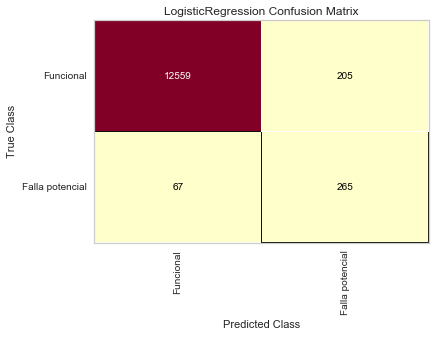



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9792302993280391
ROC AUC: 0.8910659875478096
------------------------------------------------------------
Precisión por clase: [0.99469349 0.56382979]
Sensibilidad - Recall por clase: [0.9839392  0.79819277]
F1 por clase: [0.98928712 0.66084788]
------------------------------------------------------------
F1 Macro: 0.8250675006064987
F1 Micro: 0.9792302993280391
F1 Weighted: 0.9809607748627368
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8910659875478095
Sensibilidad - Recall Micro: 0.9792302993280391
Sensibilidad - Recall Weighted: 0.9792302993280391
------------------------------------------------------------
Precisión Macro: 0.7792616384293134
Precisión Micro: 0.9792302993280391
Precisión Weighted: 0.9837705552023438
------------------------------------------------------------
Verdaderos positivos - True Positives: 265
Verdaderos negativos - True Negatives: 12559
Falsos positiv

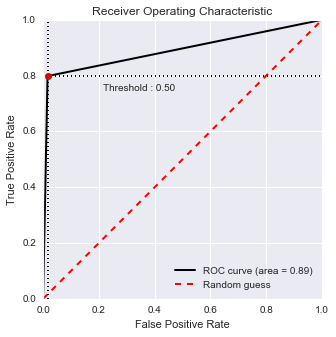

In [14]:
label_pred1 = modelo1.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1, label_pred1)

## Stratified k-fold cross-validation

Evaluaremos el modelo utilizando validación cruzada estratificada repetida de k veces, con 3 repeticiones y 10 pliegues. Informaremos la desviación media y estándar de la precisión del modelo en todas las repeticiones y pliegues

In [15]:
# evaluar 
model = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.948 (0.004)


El resultado es una exactitud media de 0.948 con una desviacion estandar de 0.004

## Ajuste de hiperparametros


### Ajustar C

In [19]:
def get_models():
    models = dict()
    for i in [0.001, 0.01, 0.1, 1, 7, 10, 25, 50, 100, 1000]:
        models[str(i)] = LogisticRegression(C=i)
    return models

# evaluar usando cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


>0.001 0.937 (0.004)
>0.01 0.944 (0.004)
>0.1 0.947 (0.004)
>1 0.948 (0.003)
>7 0.949 (0.004)
>10 0.948 (0.003)
>25 0.948 (0.003)
>50 0.948 (0.003)
>100 0.948 (0.003)
>1000 0.948 (0.003)


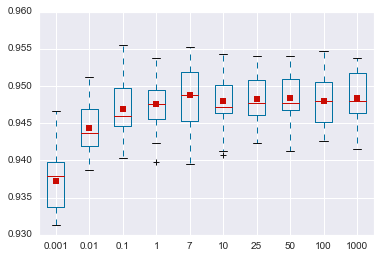

In [20]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Grid Search with Cross Validation

In [21]:

model = LogisticRegression()
parameters= {'C': [6, 7, 10, 25, 50, 100, 500, 1000],
            'penalty': ['l1', 'l2']                      
            }  
acc_scorer=make_scorer(fbeta_score, beta=1)

grid = GridSearchCV(estimator = model, param_grid=parameters, cv=3, verbose=2, scoring=acc_scorer, n_jobs = -1)

%time grid.fit(data_train, label_train)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  8.9min finished
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 8min 56s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [6, 7, 10, 25, 50, 100, 500, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(fbeta_score, beta=1), verbose=2)

In [22]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'C': 50, 'penalty': 'l2'}
0.9474111817797765
9


In [23]:
modelo2a= grid.best_estimator_
modelo2a.fit(data_train, label_train)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
label_pred2a = modelo2a.predict(data_test)



MATRIZ DE CONFUSION




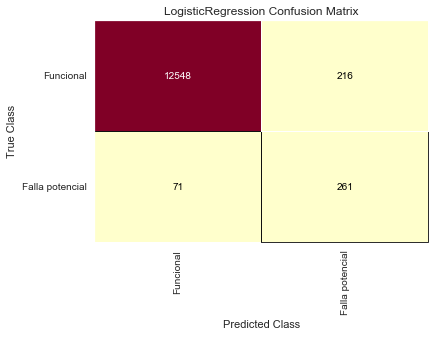



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9780849114233354
ROC AUC: 0.884610991757692
------------------------------------------------------------
Precisión por clase: [0.99437356 0.54716981]
Sensibilidad - Recall por clase: [0.98307741 0.78614458]
F1 por clase: [0.98869322 0.64524104]
------------------------------------------------------------
F1 Macro: 0.8169671290952398
F1 Micro: 0.9780849114233354
F1 Weighted: 0.9799862769672091
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.884610991757692
Sensibilidad - Recall Micro: 0.9780849114233354
Sensibilidad - Recall Weighted: 0.9780849114233354
------------------------------------------------------------
Precisión Macro: 0.77077168749729
Precisión Micro: 0.9780849114233354
Precisión Weighted: 0.9830363885225408
------------------------------------------------------------
Verdaderos positivos - True Positives: 261
Verdaderos negativos - True Negatives: 12548
Falsos positivos -

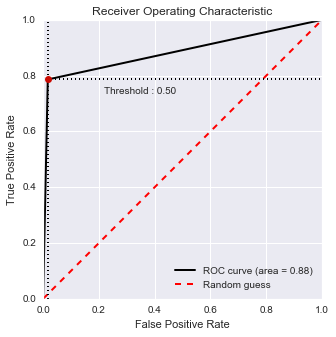

In [26]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo2a, label_pred2a)

## Regresión logística ponderada 

Clasificacion binaria con base desequilibrada y ponderacion de pesos


In [50]:
# base desequilibrada sin sobremuestreo, incluyendo la variable ciclo ID
data_train=train.iloc[:,np.r_[1:26]]
label_train=train.iloc[:,27]
data_test=test.iloc[:,np.r_[1:26]]
label_test=test.iloc[:,27]


Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

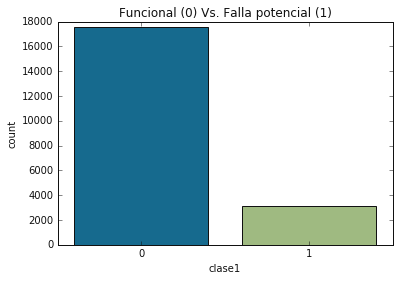

In [51]:
# conteo de observaciones por clase de la base entrenamiento
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

## Logistic regression Classifier hiperparametros por defecto con base desequilibrada

In [52]:
modelo3=LogisticRegression()
modelo3.fit(data_train, label_train)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)



MATRIZ DE CONFUSION




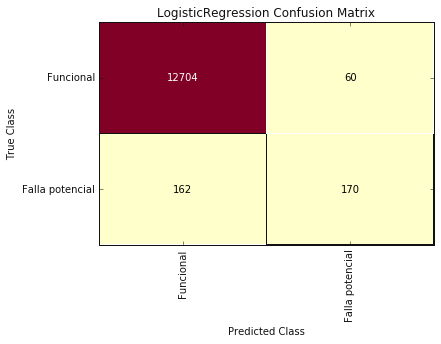



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9830482590103848
ROC AUC: 0.7536737359969493
------------------------------------------------------------
Precisión por clase: [0.98740867 0.73913043]
Sensibilidad - Recall por clase: [0.99529928 0.51204819]
F1 por clase: [0.99133828 0.60498221]
------------------------------------------------------------
F1 Macro: 0.7981602409320705
F1 Micro: 0.9830482590103848
F1 Weighted: 0.9815436652778183
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7536737359969492
Sensibilidad - Recall Micro: 0.9830482590103848
Sensibilidad - Recall Weighted: 0.9830482590103848
------------------------------------------------------------
Precisión Macro: 0.8632695544035848
Precisión Micro: 0.9830482590103848
Precisión Weighted: 0.9811145097432286
------------------------------------------------------------
Verdaderos positivos - True Positives: 170
Verdaderos negativos - True Negatives: 12704
Falsos positiv

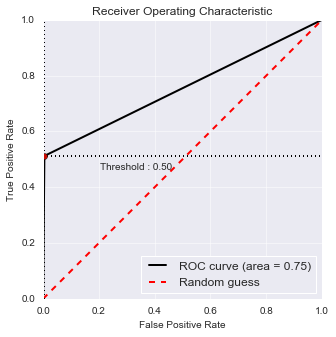

In [53]:
label_pred3 = modelo3.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo3, label_pred3)

## Grid Search Weighted Logistic Regression, con validacion cruzada estratificada

In [58]:
# definir el modelo
model = LogisticRegression()
# defini cuadricula
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)

# definir procedimiento de evaluacion 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

acc_scorer=make_scorer(fbeta_score, beta=2)

# grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring=acc_scorer, verbose=2)

# ejecutar grid search
grid_result = grid.fit(data_train, label_train)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s finished
C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [59]:
# reportar la mejor configuracion
print('mejor: %f usando %s' % (grid_result.best_score_, grid_result.best_params_))
# reportar las mejores configuraciones
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

mejor: 0.877784 usando {'class_weight': {0: 1, 1: 10}}
0.795257 (0.006213) with: {'class_weight': {0: 1, 1: 1}}
0.877784 (0.003124) with: {'class_weight': {0: 1, 1: 10}}
0.749925 (0.026070) with: {'class_weight': {0: 1, 1: 100}}


La mejor configuracion es 0:1, 1:10

In [61]:
modelo4=LogisticRegression(class_weight={0:1,1:10})
modelo4.fit(data_train, label_train)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight={0: 1, 1: 10}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)



MATRIZ DE CONFUSION




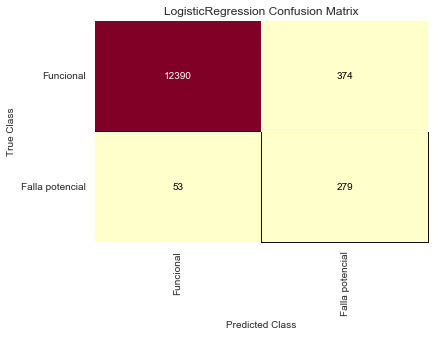



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9673946243127672
ROC AUC: 0.9055301431360038
------------------------------------------------------------
Precisión por clase: [0.99574058 0.42725881]
Sensibilidad - Recall por clase: [0.97069884 0.84036145]
F1 por clase: [0.98306026 0.56649746]
------------------------------------------------------------
F1 Macro: 0.7747788614837672
F1 Micro: 0.9673946243127672
F1 Weighted: 0.9724998724234195
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9055301431360038
Sensibilidad - Recall Micro: 0.9673946243127672
Sensibilidad - Recall Weighted: 0.9673946243127672
------------------------------------------------------------
Precisión Macro: 0.7114996912721396
Precisión Micro: 0.9673946243127672
Precisión Weighted: 0.9813288522187963
------------------------------------------------------------
Verdaderos positivos - True Positives: 279
Verdaderos negativos - True Negatives: 12390
Falsos positiv

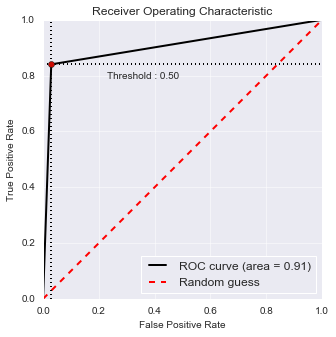

In [62]:
label_pred4 = modelo4.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo4, label_pred4)

Con la ponderacion de pesos de clase se obtiene una mejora signifiactiva del recall de la clase 1 